In [93]:
## import libraries 
import pandas as pd 
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, LearningCurveDisplay, ValidationCurveDisplay
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, RocCurveDisplay
warnings.filterwarnings("ignore")

In [94]:
## importing data as dataframe 
dataset = pd.read_csv('ext_3k_SS01.csv', delimiter=',')
dataset.head()

,Unnamed: 0,Geol,Dol_den,Lin_order1,Lin_order2,RTP,BGA,eK,eU,eTh,...,NB,CE,TH,U,TREE,MGO,CAO,K2O,SIO2,Label
0,0,5.0,0.000000,2000.000000,2000.0,95.0,103.0,2.615103,3.918492,10.630318,...,15.084587,70.451607,21.695860,3.275604,204.206741,1.347267,1.749311,2.563948,61.904854,1
1,1,4.0,56.055416,4000.000000,0.0,111.0,215.0,0.778295,1.452321,3.323865,...,12.051132,51.786007,19.682039,2.944331,153.070984,1.962155,2.313171,2.118318,59.224022,1
2,2,2.0,56.504696,4000.000000,2000.0,135.0,79.0,2.070916,2.353328,7.697129,...,12.534903,56.348896,19.435690,3.066755,166.614227,1.841425,2.253468,2.117754,59.508335,1
3,3,4.0,91.839142,2828.427002,2000.0,215.0,235.0,0.477424,0.903403,2.640520,...,11.985773,48.069935,25.368578,2.714173,142.212387,2.002360,2.403271,2.006156,59.261391,1
4,4,2.0,59.965004,2000.000000,2000.0,207.0,111.0,1.549667,1.518649,6.601230,...,12.144293,45.311413,14.967334,2.485139,133.616608,1.710467,2.172972,2.015727,58.937630,1


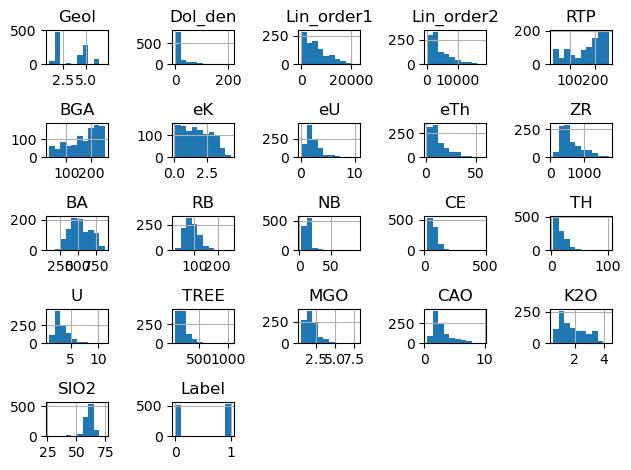

In [95]:
data_set = dataset.iloc[:,1:]
data_set.hist()
plt.tight_layout()

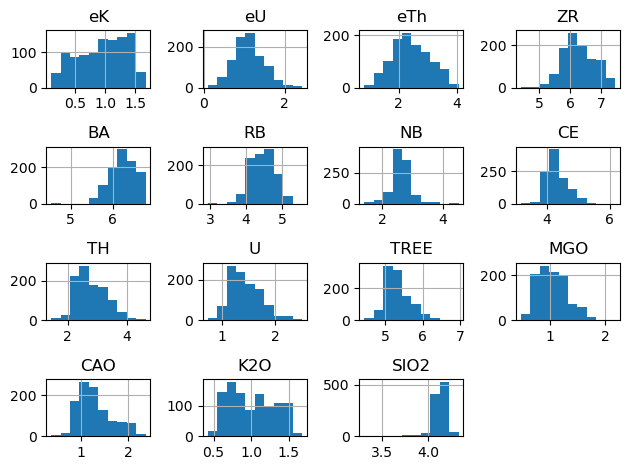

In [96]:
# Transforming geochemical variables 
dt_geochem = data_set.iloc[:,6:21]
dt_rest = data_set.iloc[:,:6]
gc_log = dt_geochem.apply(np.log1p)
gc_log.hist()
plt.tight_layout()

In [97]:
# Transformed data clubbing 
dt_tfm = pd.concat([dt_rest, gc_log], axis=1)
dt_tfm['Label'] = data_set['Label']
dt_tfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039 entries, 0 to 1038
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Geol        1039 non-null   float64
 1   Dol_den     1039 non-null   float64
 2   Lin_order1  1039 non-null   float64
 3   Lin_order2  1039 non-null   float64
 4   RTP         1039 non-null   float64
 5   BGA         1039 non-null   float64
 6   eK          1039 non-null   float64
 7   eU          1039 non-null   float64
 8   eTh         1039 non-null   float64
 9   ZR          1039 non-null   float64
 10  BA          1039 non-null   float64
 11  RB          1039 non-null   float64
 12  NB          1039 non-null   float64
 13  CE          1039 non-null   float64
 14  TH          1039 non-null   float64
 15  U           1039 non-null   float64
 16  TREE        1039 non-null   float64
 17  MGO         1039 non-null   float64
 18  CAO         1039 non-null   float64
 19  K2O         1039 non-null  

In [98]:
## Train test split 
## checking the split no much imbalance 
X = dt_tfm.drop(columns='Label')
y = dt_tfm['Label']
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
print('count of xtrain', xtrain.count())
print('count of xtest', xtest.count())
print('value count of ytrain', ytrain.value_counts())
print('value count of ytest', ytest.value_counts())

count of xtrain Geol          831
Dol_den       831
Lin_order1    831
Lin_order2    831
RTP           831
BGA           831
eK            831
eU            831
eTh           831
ZR            831
BA            831
RB            831
NB            831
CE            831
TH            831
U             831
TREE          831
MGO           831
CAO           831
K2O           831
SIO2          831
dtype: int64
count of xtest Geol          208
Dol_den       208
Lin_order1    208
Lin_order2    208
RTP           208
BGA           208
eK            208
eU            208
eTh           208
ZR            208
BA            208
RB            208
NB            208
CE            208
TH            208
U             208
TREE          208
MGO           208
CAO           208
K2O           208
SIO2          208
dtype: int64
value count of ytrain Label
1    423
0    408
Name: count, dtype: int64
value count of ytest Label
1    106
0    102
Name: count, dtype: int64


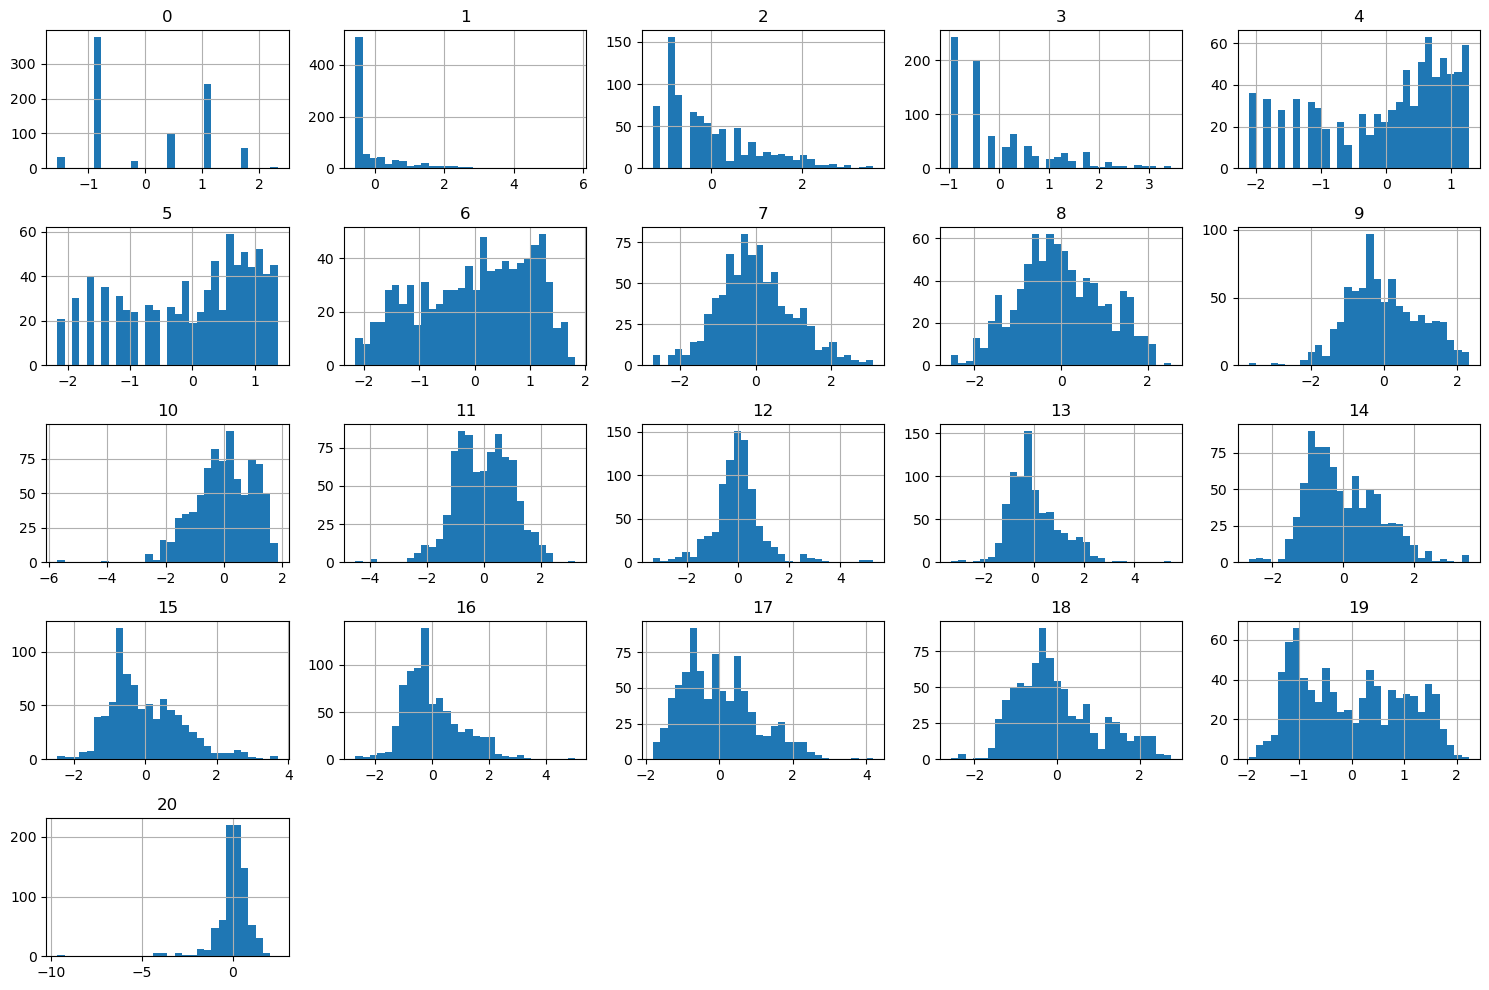

In [99]:
## strandard scaling the data 
sc = StandardScaler()
xtrain_sc = sc.fit_transform(xtrain)
xtrain_df = pd.DataFrame(xtrain_sc)
xtrain_df.hist(bins = 30, figsize=(15,10))
plt.tight_layout()

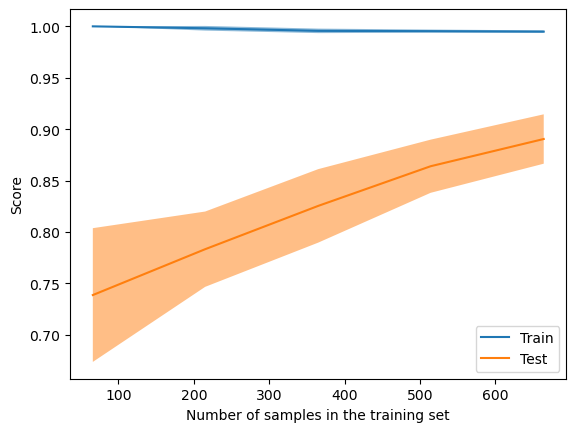

In [100]:
## Randomforest classification 
score_list = ['accuracy', 'precision', 'recall', 'f1']
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
clf = XGBClassifier(random_state=42)
cv_results = cross_validate(clf,xtrain_sc,ytrain,cv=skf,scoring = score_list,return_train_score=True)
cv_pd_res = pd.DataFrame(cv_results)
LearningCurveDisplay.from_estimator(clf,xtrain_sc,ytrain,cv=skf,shuffle=True,random_state=42)

In [101]:
cv_pd_res

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.082413,0.008999,0.910180,0.995482,0.916667,0.994100,0.905882,0.997041,0.911243,0.995569
1,0.072001,0.008000,0.903614,0.993985,0.879121,0.994083,0.941176,0.994083,0.909091,0.994083
2,0.078002,0.007999,0.873494,0.993985,0.890244,0.994083,0.858824,0.994083,0.874251,0.994083
3,0.069999,0.009001,0.855422,0.996992,0.875000,0.994135,0.833333,1.000000,0.853659,0.997059
4,0.074000,0.009003,0.903614,0.993985,0.914634,0.988338,0.892857,1.000000,0.903614,0.994135


In [102]:
## Hyper_parmaeter tuning of the RaRandomForestClassifier
score_list = ['accuracy', 'precision', 'recall', 'f1']
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
clf2 = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_alpha=8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'  # or 'auc' for binary classification
)
cv2_results = cross_validate(clf2,xtrain_sc,ytrain,cv=skf,scoring = score_list,return_train_score=True)
cv_pd_res2 = pd.DataFrame(cv2_results)

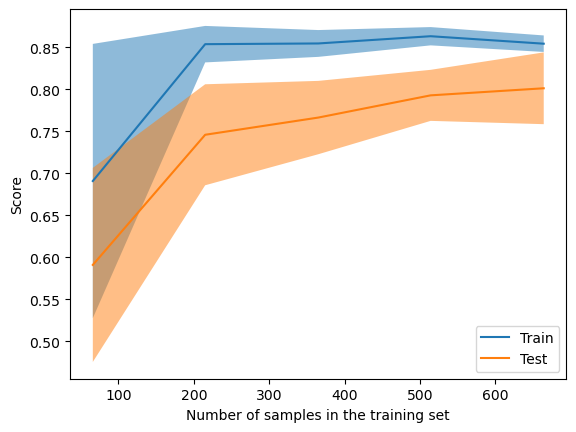

In [103]:
LearningCurveDisplay.from_estimator(clf2,xtrain_sc,ytrain,cv=skf,shuffle=True,random_state=42)

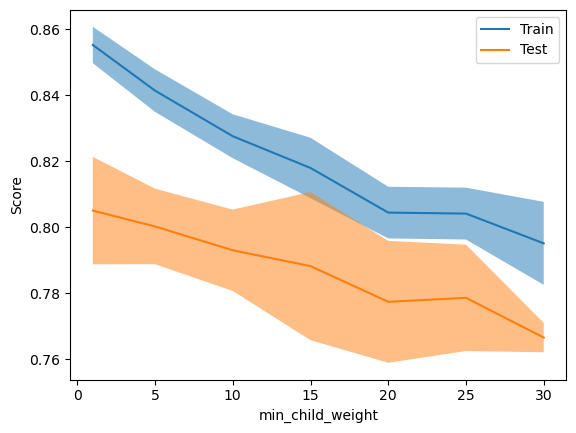

In [104]:
gamma =[1,5,10,15,20, 25, 30]
ValidationCurveDisplay.from_estimator(clf2,xtrain_sc,ytrain,param_name='min_child_weight', param_range= Lr )

In [105]:
# results of the tuned model for random set; Class label noise is hindering ~70% accuracy 
val_mean = cv_pd_res2.mean()
val_std = cv_pd_res2.std()
val_results = pd.DataFrame()
val_results['mean'] = val_mean
val_results['std'] = val_std
val_results

,mean,std
fit_time,0.125253,0.013027
score_time,0.008599,0.000548
test_accuracy,0.795361,0.048071
train_accuracy,0.853787,0.012146
test_precision,0.830771,0.037947
train_precision,0.896378,0.015985
test_recall,0.749300,0.072058
train_recall,0.806135,0.017841
test_f1,0.787339,0.055254
train_f1,0.848745,0.013031


              precision    recall  f1-score   support

           0       0.80      0.88      0.84       102
           1       0.87      0.78      0.83       106

    accuracy                           0.83       208
   macro avg       0.84      0.83      0.83       208
weighted avg       0.84      0.83      0.83       208



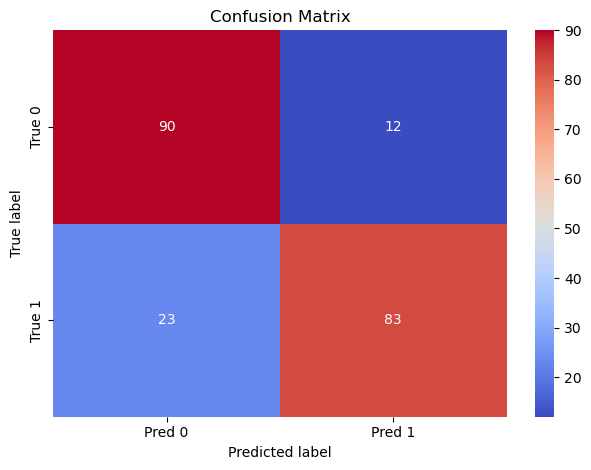

In [106]:
## Fitting the tuned model for training data and checking its prediction for test set 
clf_fit = clf2.fit(xtrain_sc,ytrain)
xtest_sc = sc.transform(xtest)
test_pred = clf2.predict(xtest_sc)
print(classification_report(y_true=ytest, y_pred=test_pred))
cm = confusion_matrix(y_true=ytest, y_pred=test_pred, labels=[0,1])
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", 
            xticklabels=["Pred 0","Pred 1"], 
            yticklabels=["True 0","True 1"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

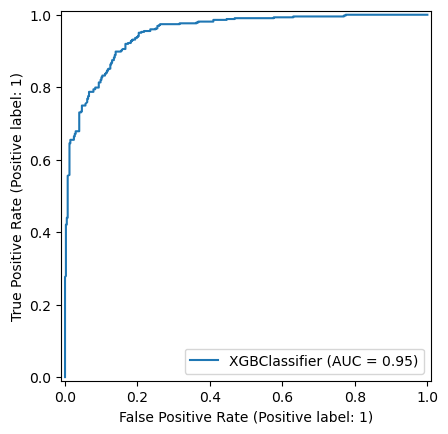

In [107]:
RocCurveDisplay.from_estimator(clf2,xtrain_sc,ytrain)

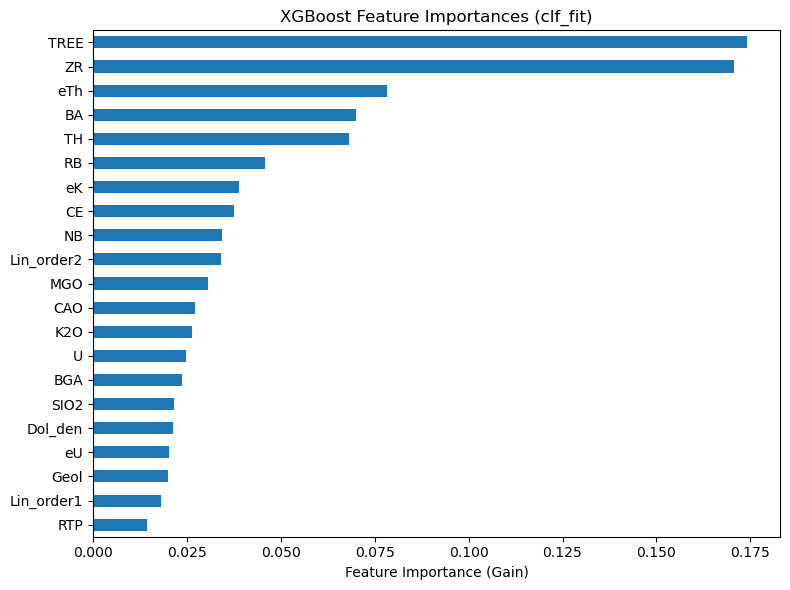

In [108]:
# Get feature importances (by default: "gain" if using .feature_importances_)
importances = clf_fit.feature_importances_

# Create a Series with feature names
feat_imp = pd.Series(importances, index=dt_tfm.columns[:-1]).sort_values(ascending=False)

# Plot as a horizontal bar chart
plt.figure(figsize=(8, 6))
feat_imp.plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance (Gain)')
plt.title('XGBoost Feature Importances (clf_fit)')
plt.tight_layout()
plt.show()

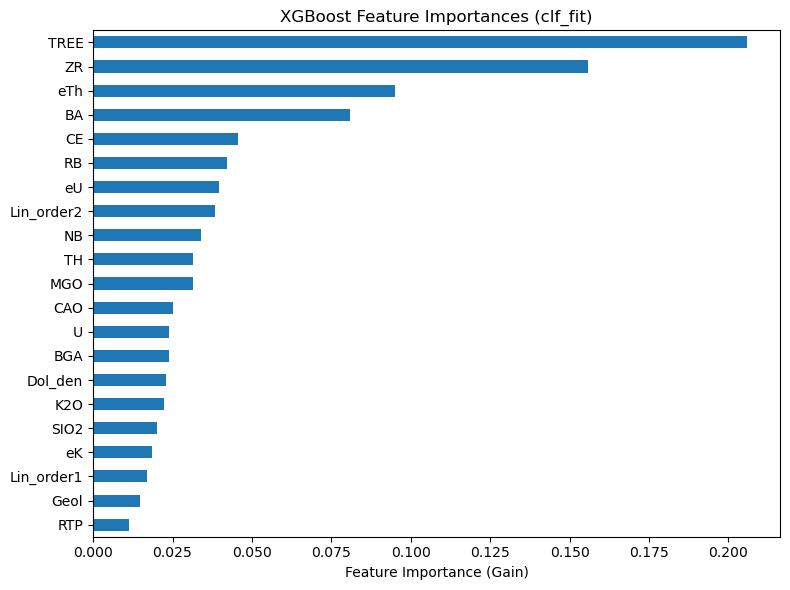

In [109]:
### Fitting model for all data 
X_sc = sc.transform(X)
clf_all = clf2.fit(X_sc,y)
importances_all = clf_all.feature_importances_

# Create a Series with feature names
feat_imp = pd.Series(importances_all, index=dt_tfm.columns[:-1]).sort_values(ascending=False)

# Plot as a horizontal bar chart
plt.figure(figsize=(8, 6))
feat_imp.plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance (Gain)')
plt.title('XGBoost Feature Importances (clf_fit)')
plt.tight_layout()
plt.show()

In [110]:
### fitting model predictions for data cube 
bandset = pd.read_csv('data_cube_ext.csv', delimiter=',')
b_set = bandset.iloc[:,1:]
b_geochem = b_set.iloc[:,6:21]
b_rest = b_set.iloc[:,:6]
log_geochem = b_geochem.apply(np.log1p)
# Transformed data clubbing 
b_final = pd.concat([b_rest, log_geochem], axis=1)
b_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10434 entries, 0 to 10433
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Geol        10434 non-null  float64
 1   Dol_den     10434 non-null  float64
 2   Lin_order1  10434 non-null  float64
 3   Lin_order2  10434 non-null  float64
 4   RTP         10434 non-null  float64
 5   BGA         10434 non-null  float64
 6   eK          10434 non-null  float64
 7   eU          10434 non-null  float64
 8   eTh         10434 non-null  float64
 9   ZR          10434 non-null  float64
 10  BA          10434 non-null  float64
 11  RB          10434 non-null  float64
 12  NB          10434 non-null  float64
 13  CE          10434 non-null  float64
 14  TH          10434 non-null  float64
 15  U           10434 non-null  float64
 16  TREE        10434 non-null  float64
 17  MGO         10434 non-null  float64
 18  CAO         10434 non-null  float64
 19  K2O         10434 non-nul

In [111]:
### Predictions using clf_all
b_sc = sc.transform(b_final)
RF_model = clf_all.predict(b_sc)

In [112]:
import rasterio
height = 111
width = 94

# 1. Read the base raster’s metadata
with rasterio.open('Base_data_cube_21.tif') as src:
    meta = src.meta.copy()
    height = src.height
    width = src.width

# 2. Suppose `preds` is your 1D int array of length height*width.
#    First, reshape it:
pred_map = RF_model.reshape((height, width))

# 3. Decide on a valid integer nodata value (e.g. -9999).
#    If your pred_map has NaNs (float), convert them to -9999 now:
if np.issubdtype(pred_map.dtype, np.floating):
    mask = np.isnan(pred_map)
    pred_map = pred_map.astype(np.int64)       # cast to integer
    pred_map[mask] = -9999

# 4. Update the metadata:
meta.update({
    'count': 1,
    'dtype': 'int32',   # or 'int32', whichever you prefer
    'nodata': -9999
})

# 5. Write out your new single-band GeoTIFF
with rasterio.open('SS01_M_XG_1k_predicted_map.tif', 'w', **meta) as dst:
    dst.write(pred_map, 1)

print("Saved 'predicted_map.tif' with nodata=-9999 and dtype=int64.")


Saved 'predicted_map.tif' with nodata=-9999 and dtype=int64.


In [113]:
# Predict class probabilities using your classifier
RF = clf_all.predict_proba(b_sc)
RF_prob = RF[:, 1]  # Probability of class 1

# Read base raster metadata
with rasterio.open('Base_data_cube_21.tif') as src:
    meta = src.meta.copy()
    height = src.height
    width = src.width

# Reshape the 1D prediction array to raster shape
pred_map = RF_prob.reshape((height, width))

# Optional: handle NaNs (though not usually present in RF_model)
if np.isnan(pred_map).any():
    pred_map = np.where(np.isnan(pred_map), -9999, pred_map)
    dtype = 'float32'
    nodata_val = -9999
else:
    dtype = 'float32'
    nodata_val = None  # Or keep existing src.meta['nodata']

# Update metadata for a single-band float raster
meta.update({
    'count': 1,
    'dtype': dtype,
    'nodata': nodata_val
})

# Write out the prediction map
with rasterio.open('SS01_M_XG_one_cls_predicted_map.tif', 'w', **meta) as dst:
    dst.write(pred_map.astype(dtype), 1)

print("Saved 'TS05_M_XG_one_cls_predicted_map.tif'.")


Saved 'TS05_M_XG_one_cls_predicted_map.tif'.
